-   How do I perform calculations on rasters and extract pixel values for defined locations?

-   Carry out operations with two rasters using Python’s built-in math operators.

## Introduction

We often want to combine values of and perform calculations on rasters to create a new output raster. This episode covers how to perform basic math operations using raster datasets. It also illustrates how to match rasters with different resolutions so that they can be used in the same calculation. As an example, we will calculate [a binary classification mask](https://custom-scripts.sentinel-hub.com/sentinel-2/burned_area_ms/) to identify burned area over a satellite scene.

The classification mask requires the following of [the Sentinel-2 bands](https://gisgeography.com/sentinel-2-bands-combinations/) (and derived indices):
* [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), derived from the **near-infrared (NIR)** and **red** bands:
$$ NDVI = \frac{NIR - red}{NIR + red} $$
* [Normalized difference water index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index), derived from the **green** and **NIR** bands:
$$ NDWI = \frac{green - NIR}{green + NIR} $$
* A custom index derived from two of the **short-wave infrared (SWIR)** bands (with wavelenght ~1600 nm and ~2200 nm, respectively):
$$ INDEX = \frac{SWIR_{16} - SWIR_{22}}{SWIR_{16} + SWIR_{22}}$$
* The **blue**, **NIR**, and **SWIR** (1600 nm) bands.

In the following, we start by computing the NDVI.

## Load and crop the Data

For this episode, we will use one of the Sentinel-2 scenes that we have already employed in the previous episodes.

Let’s load the results of our initial imagery search using `pystac`:

In [1]:
# import pystac
# items = pystac.ItemCollection.from_file('rhodes_sentinel-2.json')

In [2]:
import pystac
catalog = pystac.Catalog.from_file("./s2-rhodes/catalog.json")
items = list(catalog.get_all_items())

We then select the first item, and extract the URIs of the red and NIR bands (“red” and “nir”, respectively):

In [45]:
item = items[0]

In [6]:
red_href = item.assets["red"].get_absolute_href()
nir_href = item.assets["nir"].get_absolute_href()

Let’s load the rasters with `open_rasterio` using the argument `masked=True`.

In [7]:
import rioxarray
red = rioxarray.open_rasterio(red_href, masked=True)
nir = rioxarray.open_rasterio(nir_href, masked=True)

Let’s also restrict our analysis to the same crop field area defined in the previous episode by clipping the rasters
using a bounding box:

In [10]:
bbox = (565_000, 3_090_000, 615_000, 4_040_000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

In [15]:
red.y

<xarray.DataArray 'y' (y: 10980)>
array([4100035., 4100025., 4100015., ..., 3990265., 3990255., 3990245.])
Coordinates:
  * y            (y) float64 4.1e+06 4.1e+06 4.1e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0

We can now plot the two rasters. Using `robust=True` color values are stretched between the 2nd and 98th percentiles of
the data, which results in clearer distinctions between high and low reflectances:

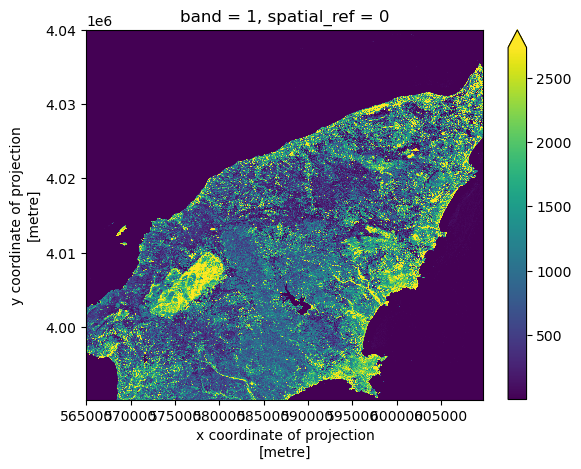

In [11]:
red_clip.plot(robust=True)

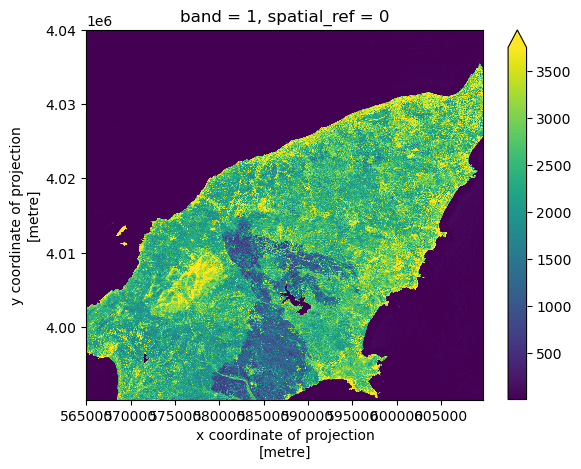

In [12]:
nir_clip.plot(robust=True)

The burned area is immediately evident as a dark spot in the NIR wavelength, due to the lack of reflection from the vegetation. 

## Raster Math

We can perform raster calculations by subtracting (or adding,
multiplying, etc.) two rasters. In the geospatial world, we call this
“raster math”, and typically it refers to operations on rasters that
have the same width and height (including `nodata` pixels).
We can check the shapes of the two rasters in the following way:

In [16]:
print(red_clip.shape, nir_clip.shape)

(1, 4976, 4478) (1, 4976, 4478)


The shapes of the two rasters match (and, not shown, the coordinates and the CRSs match too). 

Let’s now compute the NDVI as a new raster using the formula presented above.
We’ll use `rioxarray` objects so that we can easily plot our result and keep
track of the metadata.

In [17]:
ndvi = (nir_clip - red_clip)/ (nir_clip + red_clip)
print(ndvi)

<xarray.DataArray (band: 1, y: 4976, x: 4478)>
array([[[0.        , 0.        , 0.        , ..., 0.71428573,
         0.8888889 , 0.6       ],
        [0.        , 0.        , 0.        , ..., 0.84615386,
         0.8666667 , 0.8888889 ],
        [0.        , 0.        , 0.        , ..., 0.33333334,
         0.        , 0.84615386],
        ...,
        [0.71428573, 0.        , 0.        , ..., 0.7777778 ,
         0.90909094, 0.9354839 ],
        [0.7777778 , 0.        , 0.        , ..., 0.875     ,
         0.        , 0.90909094],
        [0.        , 0.        , 0.        , ..., 0.9375    ,
         0.6       , 0.6666667 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.65e+05 5.65e+05 5.65e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 4.04e+06 4.04e+06 4.04e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0


We can now plot the output NDVI:

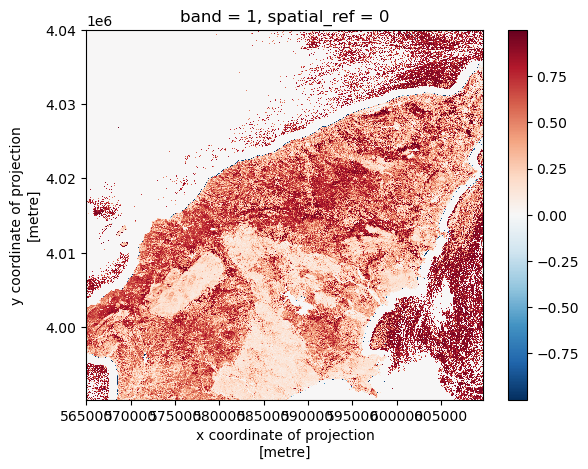

In [21]:
ndvi.plot()

Notice that the range of values for the output NDVI is between -1 and 1.
Does this make sense for the computed value?

Maps are great, but it can also be informative to plot histograms of values to better understand the distribution. We can accomplish this using a built-in xarray method we have already been using: `plot.hist()`

(array([2.796500e+04, 3.532000e+03, 3.717000e+03, 7.341000e+03,
        8.421183e+06, 2.809737e+06, 3.377290e+06, 2.678634e+06,
        2.420595e+06, 2.531979e+06]),
 array([-9.98421490e-01, -7.98607051e-01, -5.98792613e-01, -3.98978174e-01,
        -1.99163735e-01,  6.50703907e-04,  2.00465143e-01,  4.00279582e-01,
         6.00094020e-01,  7.99908459e-01,  9.99722898e-01]),
 <BarContainer object of 10 artists>)

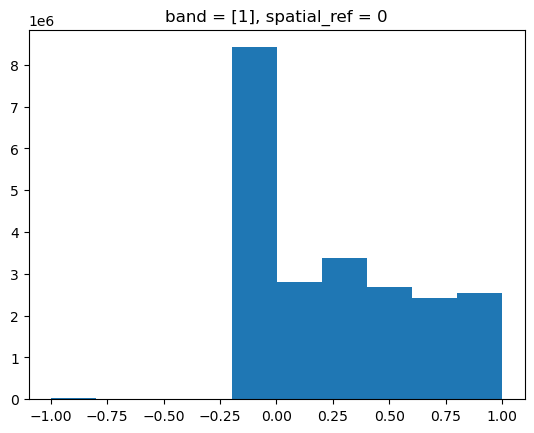

In [22]:
ndvi.plot.hist()

We see that most of the values are included in the range 0 to 1, which we can use to limit the plotted range:

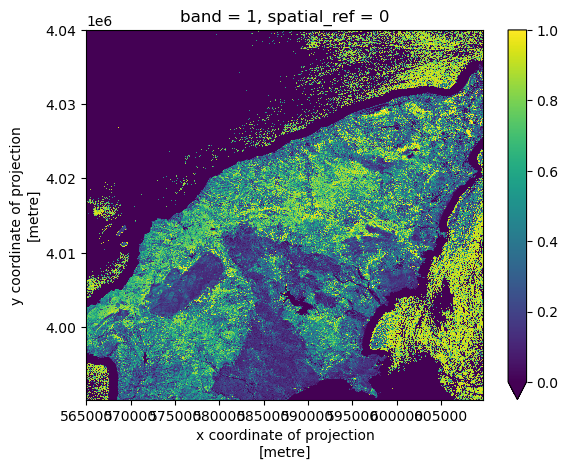

In [23]:
ndvi.plot(vmin=0, vmax=1)

### Exercise: NDWI and custom index to detect burned areas

Calculate the other two indices required to compute the burned area classification mask, specifically:

* The [normalized difference water index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index), derived from the **green** and **NIR** bands (with band ID "green" and "nir", respectively):
$$ NDWI = \frac{green - NIR}{green + NIR} $$
* A custom index derived from the  1600 nm and the 2200 nm **short-wave infrared (SWIR)** bands ( "swir16" and "swir22", respectively):
$$ INDEX = \frac{SWIR_{16} - SWIR_{22}}{SWIR_{16} + SWIR_{22}}$$

What challenge do you foresee in combining the information from all computed indices?

In [28]:
def get_band_and_clip(item, band_name, bbox):
    href = item.assets[band_name].get_absolute_href()
    band = rioxarray.open_rasterio(href, masked=True)
    return band.rio.clip_box(*bbox)

In [29]:
green_clip = get_band_and_clip(item, 'green', bbox)
swir16_clip = get_band_and_clip(item, 'swir16', bbox)
swir22_clip = get_band_and_clip(item, 'swir22', bbox)

In [30]:
ndwi = (green_clip - nir_clip)/(green_clip + nir_clip)
index = (swir16_clip - swir22_clip)/(swir16_clip + swir22_clip)

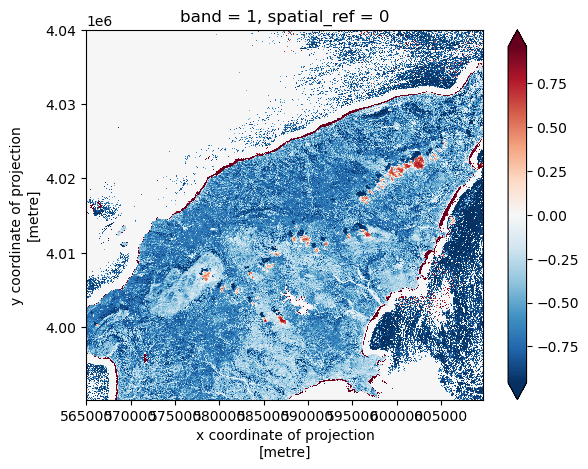

In [31]:
ndwi.plot(robust=True)

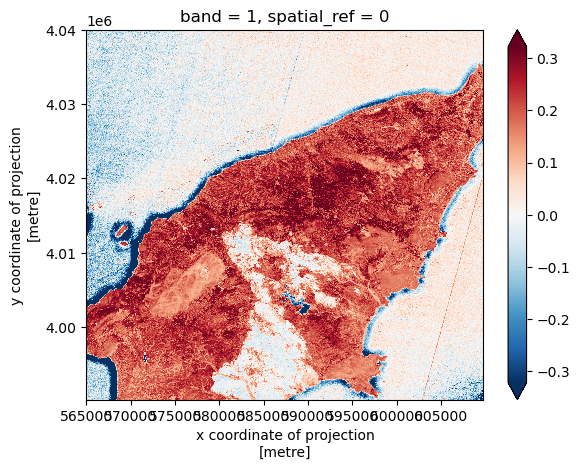

In [33]:
index.plot(robust=True)

The challenge in combining the different indices is that the SWIR bands (and thus the derived custom index) have lower resolution:

In [35]:
ndvi.rio.resolution(), ndwi.rio.resolution(), index.rio.resolution()

((10.0, -10.0), (10.0, -10.0), (20.0, -20.0))

We solve the issue by using the `reproject_match` method, which reprojects, clips and match the resolution of a raster using another raster as a template. We use the NDVI raster as a template, and match `index` and `swir16` to its resolution and extent: 

In [37]:
index_match = index.rio.reproject_match(ndvi)
swir16_clip_match = swir16_clip.rio.reproject_match(ndvi)

In [39]:
index_match.rio.resolution(), swir16_clip_match.rio.resolution()

((10.0, -10.0), (10.0, -10.0))

Finally, we also fetch the blue band data:

In [40]:
blue_clip = get_band_and_clip(item, 'blue', bbox)

We can now go ahead and compute the binary classification mask for burned areas. Note that we need to convert the unit of the Sentinel-2 bands [from digital numbers to reflectance](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#units) (this is achieved by dividing by 10,000):

In [42]:
burned = (
    (ndvi <= 0.3) & 
    (ndwi <= 0.1) &
    ((index_match + nir_clip/10_000) <= 0.1) &
    ((blue_clip/10_000) <= 0.1) & 
    ((swir16_clip_match/10_000) >= 0.1)
)

The classification mask has a single element along the "band" axis, we can drop this dimension in the following way: 

In [44]:
burned = burned.squeeze()

Let's now fetch and visualize the true color image of Rhodes, after coloring the pixels identified as burned area in red:  

In [46]:
visual_href = item.assets['visual'].get_absolute_href()
visual = rioxarray.open_rasterio(visual_href)
visual_clip = visual.rio.clip_box(*bbox)

In [47]:
# set red channel to max (255), green and blue channels to min (0).
visual_clip[0] = visual_clip[0].where(~burned, 255)
visual_clip[1:3] = visual_clip[1:3].where(~burned, 0)

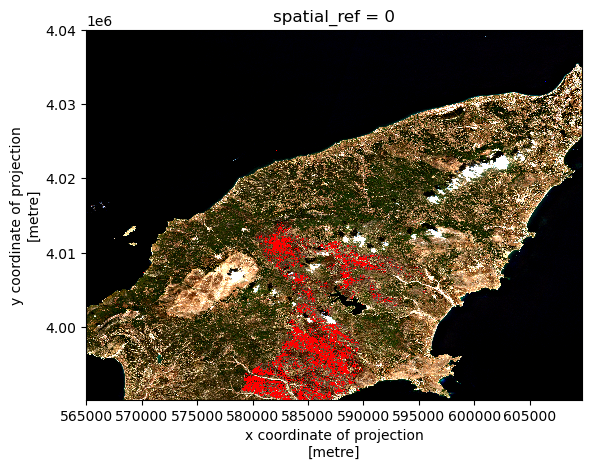

In [49]:
visual_clip.plot.imshow()